In [3]:
import pandas as pd
from scipy.io import loadmat
import h5py
import numpy as np
import torch
import torch.nn as nn
from torcheeg.models import EEGNet
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut

In [4]:
class SoftDiceLoss(nn.Module):
    '''
    soft-dice loss, useful in binary segmentation
    '''
    def __init__(self,
                 p=1,
                 smooth=1):
        super(SoftDiceLoss, self).__init__()
        self.p = p
        self.smooth = smooth

    def forward(self, logits, labels):
        '''
        inputs:
            logits: tensor of shape (N, H, W, ...)
            label: tensor of shape(N, H, W, ...)
        output:
            loss: tensor of shape(1, )
        '''
        probs = logits
        numer = (probs * labels).sum()
        denor = (probs.pow(self.p) + labels.pow(self.p)).sum()
        loss = 1. - (2 * numer + self.smooth) / (denor + self.smooth)
        return loss

In [5]:
d = h5py.File('/home/desktop/Desktop/22104412_Docs/MiceEpilepsy/ProcessedData_CHBMIT/raw_segmented/final_data_chb12.mat','r')

In [6]:
final_data = {}
r = 0
for k,v in d['final_data'].items():
    f_d = []
    x = d['final_data'][k]['data']
    for i in range(x.shape[2]):
        f_d.append(x[:,:,i].transpose())
    f_d = np.array(f_d)
    r = r+f_d.shape[0]
    final_data[k] = f_d
    print(f_d.shape,k)
print(r)

(3606, 18, 256) chb12_06_edf
(3600, 18, 256) chb12_08_edf
(3612, 18, 256) chb12_09_edf
(3611, 18, 256) chb12_10_edf
(2431, 18, 256) chb12_11_edf
(3600, 18, 256) chb12_19_edf
(3600, 18, 256) chb12_20_edf
(3600, 18, 256) chb12_21_edf
(3600, 18, 256) chb12_23_edf
(3600, 18, 256) chb12_24_edf
(3600, 18, 256) chb12_27_edf
(3600, 18, 256) chb12_28_edf
(3624, 18, 256) chb12_29_edf
(3600, 18, 256) chb12_32_edf
(3600, 18, 256) chb12_33_edf
(3600, 18, 256) chb12_34_edf
(3600, 18, 256) chb12_35_edf
(3600, 18, 256) chb12_36_edf
(3616, 18, 256) chb12_37_edf
(3600, 18, 256) chb12_38_edf
(3600, 18, 256) chb12_39_edf
(3600, 18, 256) chb12_40_edf
(3600, 18, 256) chb12_41_edf
(3600, 18, 256) chb12_42_edf
85300


In [7]:
labels = pd.read_csv('./ProcessedData_CHBMIT/labels/labels_chb04.csv')

In [8]:
val = []
for i in range(len(labels)):
    val.append(int(list(labels['File_names'])[i].split('.')[0][6:8]))

In [9]:
val = np.array(val)

In [10]:
l = {}
for k,v in final_data.items():
    flab = np.zeros((v.shape[0],1))
    fname = int(list(k.split('_'))[1])
    print(fname)
    ind = np.where(val == fname)[0]
    print(ind)
    for j in ind:
        if labels.iloc[j]['Labels']:
            start = labels.iloc[j]['Start_time']
            end = labels.iloc[j]['End_time']
            print(j,start,end)
            flab[start:end] = 1
    l[k] = flab

6
[5]
8
[7]
7 6446 6557
9
[8]
10
[9]
11
[10]
19
[18]
20
[]
21
[19]
23
[21]
24
[22]
27
[25]
28
[26 27]
26 1679 1781
27 3782 3898
29
[28]
32
[31]
33
[32]
34
[33]
35
[34]
36
[35]
37
[36]
38
[37]
39
[38]
40
[39]
41
[40]
42
[41]


In [17]:
x = list(final_data.values())
x[0].shape

(3606, 18, 256)

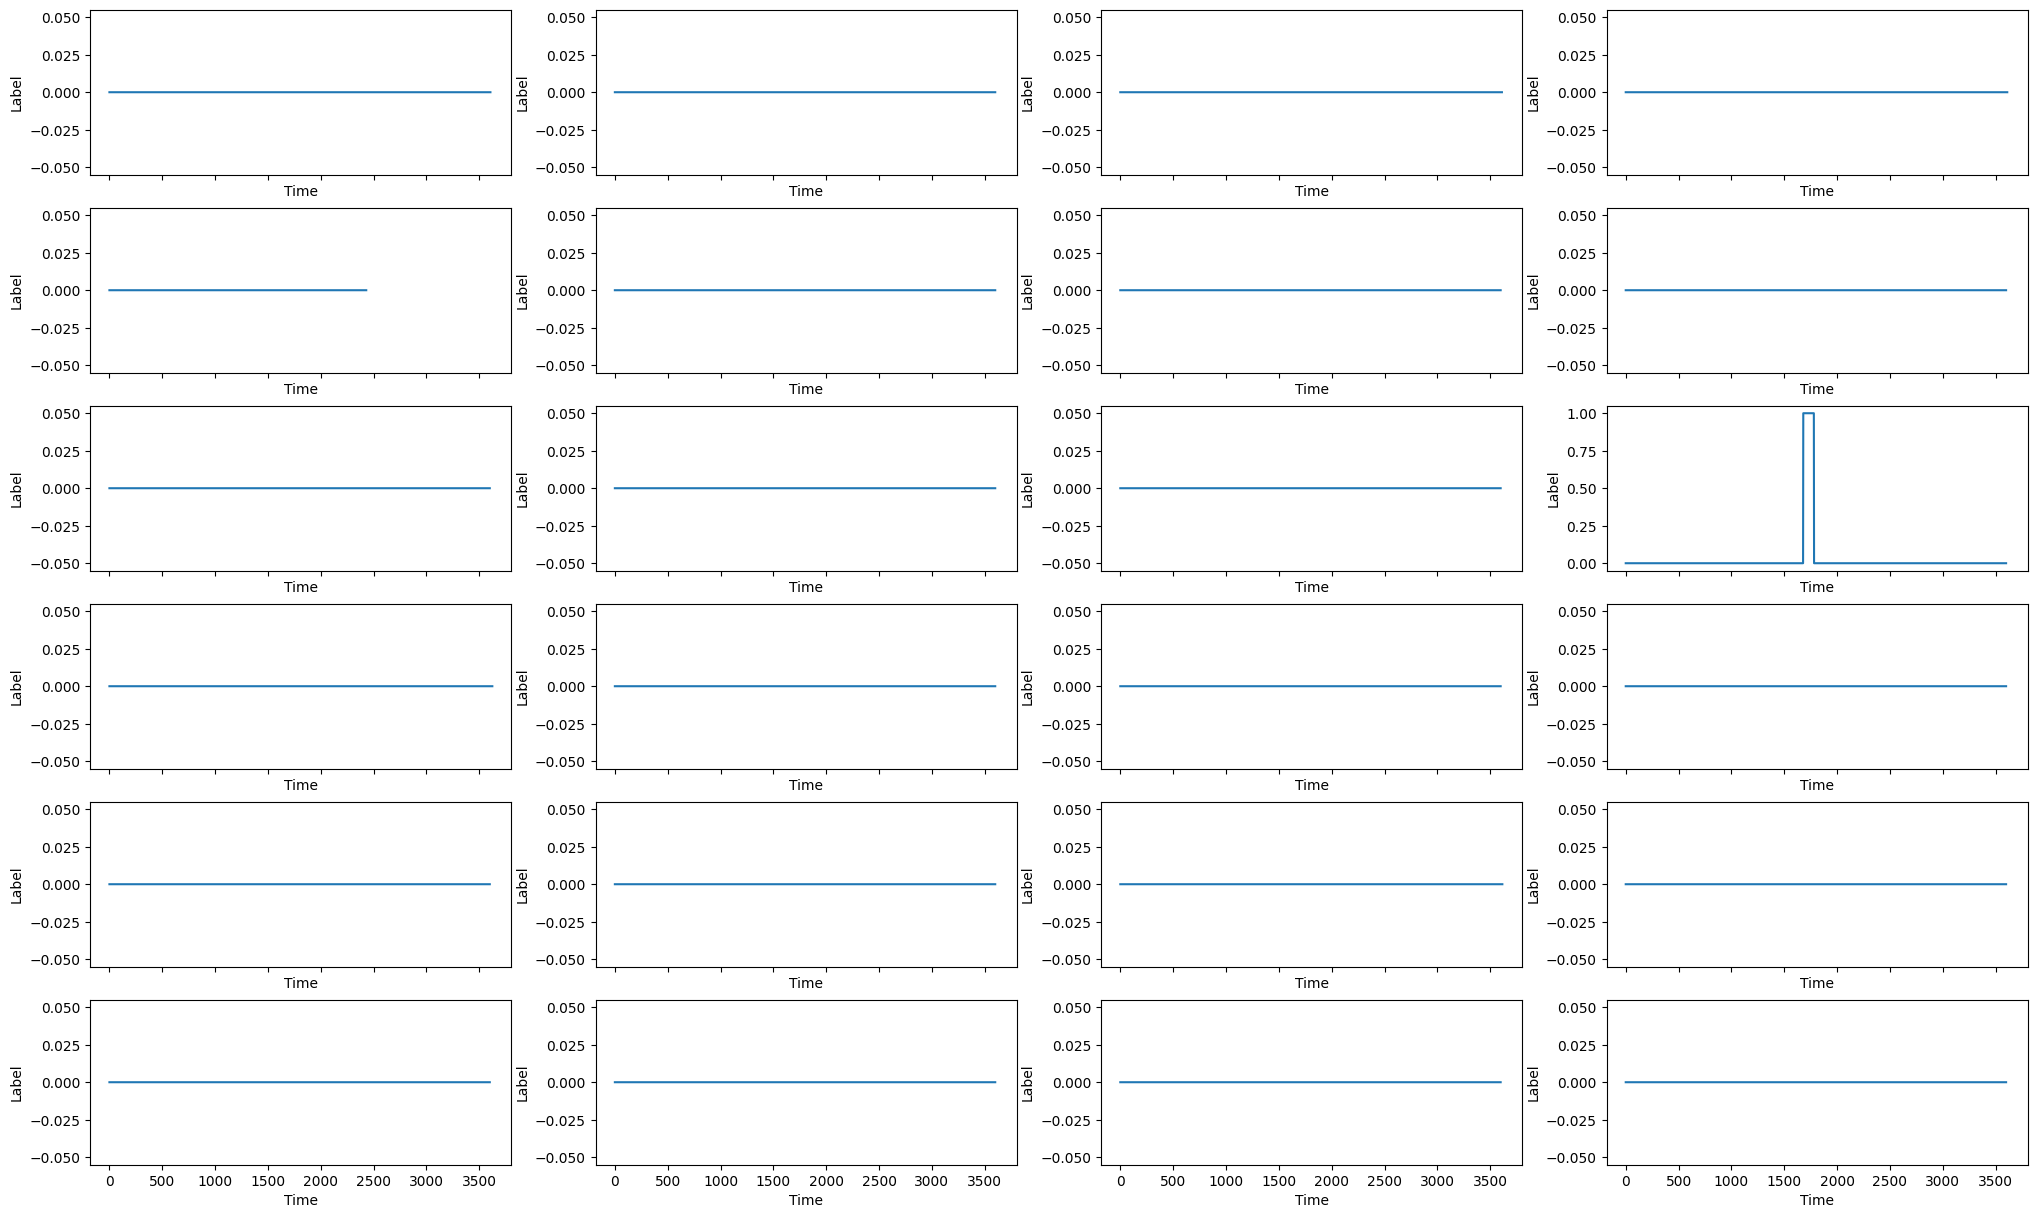

In [23]:
fig, axs = plt.subplots(6, 4, figsize=(25, 15), sharex=True)
for i,ax in enumerate(axs.flatten()):
    ax.plot(list(l.values())[i])
    ax.set_xlabel('Time')
    ax.set_ylabel('Label')
plt.show()

In [12]:
def sampling(x,y):
    number_1 = np.where(y == 1)[0]
    number_0 = np.where(y==0)[0]
    x_0 = x[number_0]
    x_0 = x_0[np.random.choice(x_0.shape[0], size=10*len(number_1), replace=False)]
    x_1 = x[number_1]
    x = np.concatenate((x_0,x_1))
    y_0 = np.zeros((x_0.shape[0],1))
    y_1 = np.ones((x_1.shape[0],1))
    y = np.concatenate((y_0,y_1))
    return x,y

In [13]:
import torch.nn.functional as F
from sklearn.metrics import f1_score

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=5, reduction='mean'):
        """
        :param alpha: Weighting factor for the class, default is 1
        :param gamma: Focusing parameter, default is 2
        :param reduction: Reduction method to apply ('none', 'mean', 'sum')
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        loss = nn.CrossEntropyLoss()
        BCE_loss = loss(inputs, targets)
        pt = torch.exp(-BCE_loss)  # prevents nans when probability is 0
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss

# Example usage:
# criterion = FocalLoss()
# loss = criterion(predictions, targets)


In [14]:
def focal_loss(labels, logits, alpha, gamma):
    """Compute the focal loss between `logits` and the ground truth `labels`.

    Focal loss = -alpha_t * (1-pt)^gamma * log(pt)
    where pt is the probability of being classified to the true class  
    
  
    pt = p (if true class), otherwise pt = 1 - p. p = sigmoid(logit).

    Args:
      labels: A float tensor of size [batch, num_classes].
      logits: A float tensor of size [batch, num_classes].
      alpha: A float tensor of size [batch_size]
        specifying per-example weight for balanced cross entropy.
      gamma: A float scalar modulating loss from hard and easy examples.

    Returns:
      focal_loss: A float32 scalar representing normalized total loss.
    """    
    BCLoss = F.binary_cross_entropy_with_logits(input = logits, target = labels,reduction = "none")

    if gamma == 0.0:
        modulator = 1.0
    else:
        modulator = torch.exp(-gamma * labels * logits - gamma * torch.log(1 + 
            torch.exp(-1.0 * logits)))

    loss = modulator * BCLoss

    weighted_loss = alpha * loss
    focal_loss = torch.sum(weighted_loss)

    focal_loss /= torch.sum(labels)
    return focal_loss

def CB_loss(labels, logits, samples_per_cls, no_of_classes, loss_type, beta, gamma):
    """Compute the Class Balanced Loss between `logits` and the ground truth `labels`.

    Class Balanced Loss: ((1-beta)/(1-beta^n))*Loss(labels, logits)
    where Loss is one of the standard losses used for Neural Networks.

    Args:
      labels: A int tensor of size [batch].
      logits: A float tensor of size [batch, no_of_classes].
      samples_per_cls: A python list of size [no_of_classes].
      no_of_classes: total number of classes. int
      loss_type: string. One of "sigmoid", "focal", "softmax".
      beta: float. Hyperparameter for Class balanced loss.
      gamma: float. Hyperparameter for Focal loss.

    Returns:
      cb_loss: A float tensor representing class balanced loss
    """
    effective_num = 1.0 - np.power(beta, samples_per_cls)
    weights = (1.0 - beta) / np.array(effective_num)
    weights = weights / np.sum(weights) * no_of_classes

    labels_one_hot = labels.float()

    weights = torch.tensor(weights).float()
    weights = weights.unsqueeze(0)
    weights = weights.cuda()
    weights = weights.repeat(labels_one_hot.shape[0],1) * labels_one_hot
    weights = weights.sum(1)
    weights = weights.unsqueeze(1)
    weights = weights.repeat(1,no_of_classes)

    if loss_type == "focal":
        cb_loss = focal_loss(labels_one_hot, logits, weights, gamma)
    elif loss_type == "sigmoid":
        cb_loss = F.binary_cross_entropy_with_logits(input = logits,target = labels_one_hot, weights = weights)
    elif loss_type == "softmax":
        pred = logits.softmax(dim = 1)
        cb_loss = F.binary_cross_entropy(input = pred, target = labels_one_hot, weight = weights)
    return cb_loss


In [15]:
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torch import nn

def get_catvalues(y_train,y_test):
    ytr = np.zeros((y_train.shape[0],2))
    yte = np.zeros((y_test.shape[0],2))
    ytr[np.where(y_train[:,0] == 1)] = [0,1]
    ytr[np.where(y_train[:,0] == 0)] = [1,0]
    yte[np.where(y_test[:,0] == 1)] = [0,1]
    yte[np.where(y_test[:,0] == 0)] = [1,0]
    samples = [np.where(y_train[:,0]==0)[0].shape[0],np.where(y_train[:,0]==1)[0].shape[0]]
    return ytr,yte, samples

class Dataset(Dataset):
        def __init__(self, data, info):
            #data loading\n",
            self.x = data
            self.y = info
            self.n_samples = data.shape[0]
    
        def __getitem__(self,index):
            t1 = self.x[index]
            t2 = self.y[index]
            t1 = torch.tensor(t1)
            t1 = t1.unsqueeze(0)
            t2 = torch.tensor(t2)
            return (t1,t2)
        
        def __len__(self):
            return self.n_samples

X = list(final_data.values())
y = list(l.values())


loo = LeaveOneOut()
trainLoss = {}
valLoss = {}
trainAcc = {}
valAcc = {}
loo.get_n_splits(X)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:

for i, (train_index, test_index) in enumerate(loo.split(X)):
    print(f"Fold {i}:")
    X_train = np.concatenate([X[tr_i] for tr_i in train_index])
    # X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X[test_index[0]]
    # X_test = X_test.reshape(X_test.shape[0],-1)
    y_train = np.concatenate([y[tr_i] for tr_i in train_index])
    y_test = y[test_index[0]]
    print('Pre Sampling : ',X_train.shape, X_test.shape, y_train.shape,y_test.shape)
    X_train,y_train = sampling(X_train,y_train)
    print('Post Sampling : ',X_train.shape, X_test.shape, y_train.shape,y_test.shape)
    y_train,y_test,samples = get_catvalues(y_train,y_test)
    print('Post Categorical : ',X_train.shape, X_test.shape, y_train.shape,y_test.shape)
    model = EEGNet(chunk_size=256,num_electrodes=18,num_classes=2)
    model = model.to(device)
    hyper_lambda = 0.5
    weights = torch.tensor([1.2, 6])
    weights = weights.to(device)
    criterion = FocalLoss()
    #criterion = SoftDiceLoss()
    tL = []
    vL = []
    tAV = []
    vAV = []
    optimizer_ft = torch.optim.Adam(model.parameters(), lr=0.001)
    trainDS = Dataset(X_train, y_train)
    trainDL = DataLoader(dataset = trainDS, batch_size = 50, shuffle = True)
 
    valDS = Dataset(X_test, y_test)
    valDL = DataLoader(dataset = valDS, batch_size = 50, shuffle = True)
    
    testDS = Dataset(X_test, y_test)
    testDL = DataLoader(dataset = testDS, batch_size = 100)
    num_epochs = 50
    batchsize = 50
    l2_lambda = 0.001
    best_acc = 0
    for epoch in range(num_epochs):
        trainAccuracy = 0
        totalLoss = 0
        with tqdm(trainDL, unit='batch') as tepoch:
            model.train()
            for imagest,lab in tepoch:
                imagest = imagest.to(device)
                lab = lab.to(device)
                optimizer_ft.zero_grad()
                outputs = (model(imagest.float()))
                _,predindex = torch.max(outputs, dim = 1)
                _,labindex = torch.max(lab, dim = 1)
                loss = CB_loss(lab.float(),outputs,samples_per_cls=samples,no_of_classes=2,loss_type='softmax',beta=0.99,gamma=2)
                #loss = criterion(outputs,lab.float())
                l2_reg = 0.0
                for param in model.parameters():
                    l2_reg += torch.norm(param, p=2) # L2 norm of the parameter
                loss += l2_lambda * l2_reg
                loss.backward()
                optimizer_ft.step()
                totalLoss+=loss.item()
                acc = (predindex==labindex).sum().item()
                trainAccuracy += acc/(lab.shape[0]*len(trainDL))
                tepoch.set_postfix(loss=loss.item(),totalLoss =totalLoss/len(trainDL), TrainAccuracy= 100.*trainAccuracy)      
            model.eval()
            with torch.no_grad():
                with tqdm(valDL, unit='batch') as tepoch:
                    total = 0
                    valAccuracy = 0
                    val_loss = 0
                    f1 = 0
                    for imagesv,labv in tepoch:
                        imagesv = imagesv.to(device)
                        labelsv = labv.to(device)
                        outval = (model(imagesv.float()))
                        _,predindexval = torch.max(outval,dim = 1)
                        _,labvalindex = torch.max(labelsv,dim = 1)
                        acc = (predindexval == labvalindex).sum().item()
                        valAccuracy +=acc/(labv.shape[0]*len(valDL))
                        lossv = CB_loss(labelsv.float(),outval,samples_per_cls=samples,no_of_classes=2,loss_type='softmax',beta=0.99,gamma=2)
                        val_loss+= lossv.item()
                        tepoch.set_postfix(lossv=lossv.item(),valLoss =val_loss/len(valDL), ValAccuracy= 100.*valAccuracy)
        print('Epoch [{}], Loss_t: {:.4f},Loss_v: {:.4f}, train_acc:{:.4f}, val_acc:{:.4f}'.format(epoch, totalLoss/len(trainDL), val_loss/len(valDL),
                                                                                                   100.*trainAccuracy,100.*valAccuracy))

        path = "./models_CNN/chb4/model_best_"+str(epoch)+"_"+str(i)+"_"+str(100.*valAccuracy) 
        if valAccuracy>best_acc:
            best_acc = valAccuracy
            model_to_save = model
            path_to_save = path
        tL.append(totalLoss/len(trainDL))
        vL.append(val_loss/len(valDL))
        tAV.append(100.*trainAccuracy)
        vAV.append( 100.*valAccuracy)
    torch.save(model_to_save.state_dict(), path_to_save)
    trainLoss[str(i)] = tL
    valLoss[str(i)] = vL
    trainAcc[str(i)] = tAV
    valAcc[str(i)] = vAV
tL = np.array(list(trainLoss.values()))
vL = np.array(list(valLoss.values()))
tAV = np.array(list(trainAcc.values()))
vAV = np.array(list(valAcc.values()))

Fold 0:
Pre Sampling :  (81694, 18, 256) (3606, 18, 256) (81694, 1) (3606, 1)
Post Sampling :  (1122, 18, 256) (3606, 18, 256) (1122, 1) (3606, 1)
Post Categorical :  (1122, 18, 256) (3606, 18, 256) (1122, 2) (3606, 2)


  0%|          | 0/23 [00:01<?, ?batch/s]


KeyboardInterrupt: 

In [34]:
import os

X = list(final_data.values())
y = list(l.values())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

predicted_val = {}
target_val = {}
for file in os.listdir('./models_CNN/chb4/'):
    pred_val = []
    gt_val = []
    print(file.split('_')[3])
    index = int(file.split('_')[3])
    X_test = X[index]
    y_test = y[index]
    model = EEGNet(chunk_size=256,num_electrodes=18,num_classes=2)
    model.load_state_dict(torch.load('./models_CNN/chb4/'+file))
    model = model.to(device)
    y_t = np.zeros((X_test.shape[0],2))
    y_t[np.where(y_test[:,0] == 1)] = [0,1]
    y_t[np.where(y_test[:,0] == 0)] = [1,0]
    y_test = y_t
    testDS = Dataset(X_test, y_test)
    testDL = DataLoader(dataset = testDS, batch_size = 1)
    model.eval()
    with torch.no_grad():
        with tqdm(testDL, unit='batch') as tepoch:
            for imagesv,labv in tepoch:
                imagesv = imagesv.to(device)
                labelsv = labv.to(device)
                outval = (model(imagesv.float()))
                _,predindexval = torch.max(outval,dim = 1)
                _,labvalindex = torch.max(labelsv,dim = 1)
                pred_val.append(predindexval)
                gt_val.append(labvalindex)
    pred_val = torch.concat(pred_val)
    pred_val = pred_val.cpu().numpy()
    predicted_val[str(index)] = pred_val
    gt_val = torch.concat(gt_val)
    gt_val = gt_val.cpu().numpy()
    target_val[str(index)] = gt_val

0


100%|██████████| 3598/3598 [00:01<00:00, 2452.34batch/s]


26


100%|██████████| 3600/3600 [00:01<00:00, 2445.95batch/s]


21


100%|██████████| 3600/3600 [00:01<00:00, 2465.96batch/s]


15


100%|██████████| 3600/3600 [00:01<00:00, 2479.96batch/s]


34


100%|██████████| 2859/2859 [00:01<00:00, 2422.94batch/s]


10


100%|██████████| 3600/3600 [00:01<00:00, 2458.08batch/s]


1


100%|██████████| 3600/3600 [00:01<00:00, 2465.47batch/s]


7


100%|██████████| 3600/3600 [00:01<00:00, 2460.79batch/s]


4


100%|██████████| 3600/3600 [00:01<00:00, 2443.77batch/s]


29


100%|██████████| 3600/3600 [00:01<00:00, 2416.89batch/s]


2


100%|██████████| 3600/3600 [00:02<00:00, 1617.83batch/s]


9


100%|██████████| 3600/3600 [00:01<00:00, 2430.20batch/s]


28


100%|██████████| 3600/3600 [00:01<00:00, 2434.34batch/s]


20


100%|██████████| 3600/3600 [00:01<00:00, 2446.17batch/s]


11


100%|██████████| 3600/3600 [00:01<00:00, 2449.05batch/s]


18


100%|██████████| 3600/3600 [00:01<00:00, 2451.03batch/s]


16


100%|██████████| 3600/3600 [00:01<00:00, 2447.86batch/s]


23


100%|██████████| 3600/3600 [00:01<00:00, 2438.05batch/s]


17


100%|██████████| 3600/3600 [00:01<00:00, 2457.65batch/s]


27


100%|██████████| 3600/3600 [00:01<00:00, 2553.35batch/s]


32


100%|██████████| 3600/3600 [00:01<00:00, 2470.73batch/s]


22


100%|██████████| 3600/3600 [00:01<00:00, 2447.69batch/s]


30


100%|██████████| 3600/3600 [00:01<00:00, 2482.51batch/s]


31


100%|██████████| 3600/3600 [00:01<00:00, 2491.59batch/s]


6


100%|██████████| 3600/3600 [00:01<00:00, 2485.54batch/s]


19


100%|██████████| 3600/3600 [00:01<00:00, 2506.12batch/s]


25


100%|██████████| 3600/3600 [00:01<00:00, 2540.18batch/s]


3


100%|██████████| 3600/3600 [00:01<00:00, 2516.12batch/s]


33


100%|██████████| 3600/3600 [00:01<00:00, 2439.41batch/s]


5


100%|██████████| 3600/3600 [00:01<00:00, 2477.33batch/s]


13


100%|██████████| 3600/3600 [00:01<00:00, 2460.26batch/s]


8


100%|██████████| 3600/3600 [00:01<00:00, 2470.32batch/s]


24


100%|██████████| 3600/3600 [00:01<00:00, 2463.31batch/s]


12


100%|██████████| 3600/3600 [00:01<00:00, 2352.98batch/s]


14


100%|██████████| 3600/3600 [00:01<00:00, 2453.51batch/s]


In [35]:
from sklearn.metrics import f1_score

gt = np.concatenate(list(target_val.values()))
pred = np.concatenate(list(predicted_val.values()))

score = f1_score(gt,pred)

In [36]:
print('F1_score:',score)

F1_score: 0.8717339667458432


In [37]:
predicted_val.keys()

dict_keys(['0', '26', '21', '15', '34', '10', '1', '7', '4', '29', '2', '9', '28', '20', '11', '18', '16', '23', '17', '27', '32', '22', '30', '31', '6', '19', '25', '3', '33', '5', '13', '8', '24', '12', '14'])

In [38]:
import pandas as pd

df = pd.DataFrame()

max_length = max(len(predicted_val[str(i)]) for i in range(len(predicted_val.keys())))
df['S.No'] = range(1, max_length + 1)

fk = list(final_data.keys())
for i in range(len(list(predicted_val.keys()))):
    k = fk[i]
    data = predicted_val[str(i)]
    df[k] = pd.Series(data)

df.to_csv('./predictions/prediction_chb_04.csv', index=False)
